In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

In [3]:
def calculate_fisher_score(X, y):
    """Tính toán chỉ số Fisher cho từng đặc trưng"""
    labels = np.unique(y)
    if len(labels) != 2: return 0
    
    x0 = X[y == labels[0]]
    x1 = X[y == labels[1]]
    
    # Mean và Variance của từng lớp
    mu0, mu1 = np.mean(x0, axis=0), np.mean(x1, axis=0)
    var0, var1 = np.var(x0, axis=0), np.var(x1, axis=0)
    
    # Công thức Fisher: (mu1 - mu2)^2 / (var1 + var2)
    score = (mu0 - mu1)**2 / (var0 + var1 + 1e-6)
    return np.mean(score) # Trả về trung bình độ phân tách của không gian n chiều

In [57]:
CONFIGS = {
    'NSL-KDD': {
        'alpha': 0.76,  # Tăng: giữ thông tin quan trọng hơn
        'beta':  0.16,  # Giảm: Fisher 2 lớp đơn giản, không cần ưu tiên cao
        'gamma': 0.08,
    },
    'UNSW-NB15': {
        'alpha': 0.55,  # Cao hơn: dữ liệu phức tạp, nhiều pattern ẩn
        'beta':  0.35,  # Giảm thêm
        'gamma': 0.10,
    }
}

In [58]:
data_path = 'processed_data/NSL_KDD_Train_Cleaned.csv'
n_components = 4
df = pd.read_csv(data_path)
X = df.drop('label', axis=1)
y = df['label']

In [63]:
import pandas as pd
from IPython.display import display

data_type = 'NSL-KDD' 
alpha = CONFIGS[data_type]['alpha']
beta = CONFIGS[data_type]['beta']
gamma = CONFIGS[data_type]['gamma']
print(gamma)

n_range = range(2, 11)
results = []

# Bước 1: Thu thập chỉ số thô
for n in n_range:
    pca = PCA(n_components=n, random_state=42)
    X_pca = pca.fit_transform(X)
    
    V_n = np.sum(pca.explained_variance_ratio_)
    S_n = calculate_fisher_score(X_pca, y)
    
    results.append({
        'n': n,
        'V_n': V_n,
        'S_n': S_n
    })

# Bước 2: Chuẩn hóa và tính toán Hàm mục tiêu F(n)
s_min = min(r['S_n'] for r in results)
s_max = max(r['S_n'] for r in results)
s_denom = (s_max - s_min) if s_max > s_min else 1.0

for r in results:
    r['S_norm'] = (r['S_n'] - s_min) / s_denom  # Min-max normalization
    r['Q_n'] = r['n'] / max(n_range)           # Hardware cost
    r['f_score'] = alpha * r['V_n'] + beta * r['S_norm'] - gamma * r['Q_n']

# Bước 3: Tạo DataFrame và hiển thị bảng so sánh
df_compare = pd.DataFrame(results)
df_compare.columns = ['Qubits (n)', 'Variance V(n)', 'Fisher S(n)', 'Norm Fisher', 'Hardware Cost', 'Objective F(n)']

# Tìm n tối ưu
best_idx = df_compare['Objective F(n)'].idxmax()
best_n_val = df_compare.loc[best_idx, 'Qubits (n)']

def highlight_best(s):
    is_max = s == s.max()
    return ['background-color: #d1e7dd; font-weight: bold' if v else '' for v in is_max]

print(f"--- BẢNG SO SÁNH TỐI ƯU HÓA ĐA MỤC TIÊU ({data_type}) ---")
display(df_compare.style.format({
    'Variance V(n)': '{:.2%}',
    'Fisher S(n)': '{:.4f}',
    'Norm Fisher': '{:.4f}',
    'Hardware Cost': '{:.2f}',
    'Objective F(n)': '{:.4f}'
}).apply(highlight_best, subset=['Objective F(n)']))

print(f"✅ Số lượng Qubit tối ưu được chọn: {int(best_n_val)}")
print(f"🚀 Điểm mục tiêu cao nhất: {df_compare.loc[best_idx, 'Objective F(n)']:.4f}")
n_chosen = int(best_n_val)

0.08
--- BẢNG SO SÁNH TỐI ƯU HÓA ĐA MỤC TIÊU (NSL-KDD) ---


,Qubits (n),Variance V(n),Fisher S(n),Norm Fisher,Hardware Cost,Objective F(n)
0,2,56.90%,1.6915,1.0000,0.20,0.5764
1,3,67.84%,1.1337,0.5791,0.30,0.5843
2,4,72.92%,0.8721,0.3817,0.40,0.5832
3,5,77.02%,0.7103,0.2596,0.50,0.5869
4,6,79.84%,0.5922,0.1705,0.60,0.5861
5,7,82.11%,0.5202,0.1162,0.70,0.5866
6,8,84.09%,0.4576,0.0689,0.80,0.5861
7,9,85.59%,0.4069,0.0307,0.90,0.5834
8,10,86.97%,0.3662,0.0000,1.00,0.5810


✅ Số lượng Qubit tối ưu được chọn: 5
🚀 Điểm mục tiêu cao nhất: 0.5869


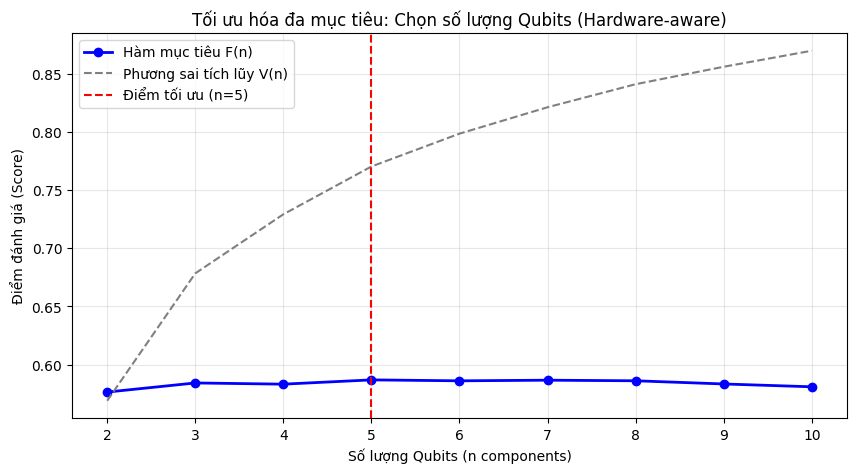

In [64]:
# Lấy dữ liệu từ danh sách results đã chạy ở ô trên
n_vals = [r['n'] for r in results]
f_vals = [r['f_score'] for r in results]
v_vals = [r['V_n'] for r in results] # Đã sửa từ 'variance' thành 'V_n'

plt.figure(figsize=(10, 5))

# Vẽ đường hàm mục tiêu F(n)
plt.plot(n_vals, f_vals, 'o-', label='Hàm mục tiêu F(n)', color='blue', linewidth=2)

# Vẽ đường phương sai tích lũy V(n)
plt.plot(n_vals, v_vals, '--', label='Phương sai tích lũy V(n)', color='gray')

# Đánh dấu điểm tối ưu
plt.axvline(x=best_n_val, color='red', linestyle='--', label=f'Điểm tối ưu (n={int(best_n_val)})')

plt.title('Tối ưu hóa đa mục tiêu: Chọn số lượng Qubits (Hardware-aware)')
plt.xlabel('Số lượng Qubits (n components)')
plt.ylabel('Điểm đánh giá (Score)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

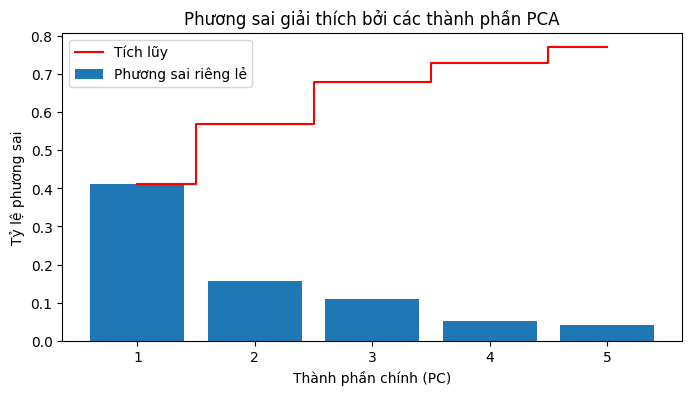

In [67]:
pca = PCA(n_components=n_chosen)
pca_result = pca.fit_transform(X)

# --- TRỰC QUAN HÓA 1: Tỷ lệ phương sai tích lũy ---
plt.figure(figsize=(8, 4))
plt.bar(range(1, n_chosen + 1), pca.explained_variance_ratio_, label='Phương sai riêng lẻ')
plt.step(range(1, n_chosen + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', color='red', label='Tích lũy')
plt.title('Phương sai giải thích bởi các thành phần PCA')
plt.xlabel('Thành phần chính (PC)')
plt.ylabel('Tỷ lệ phương sai')
plt.legend()
plt.show()

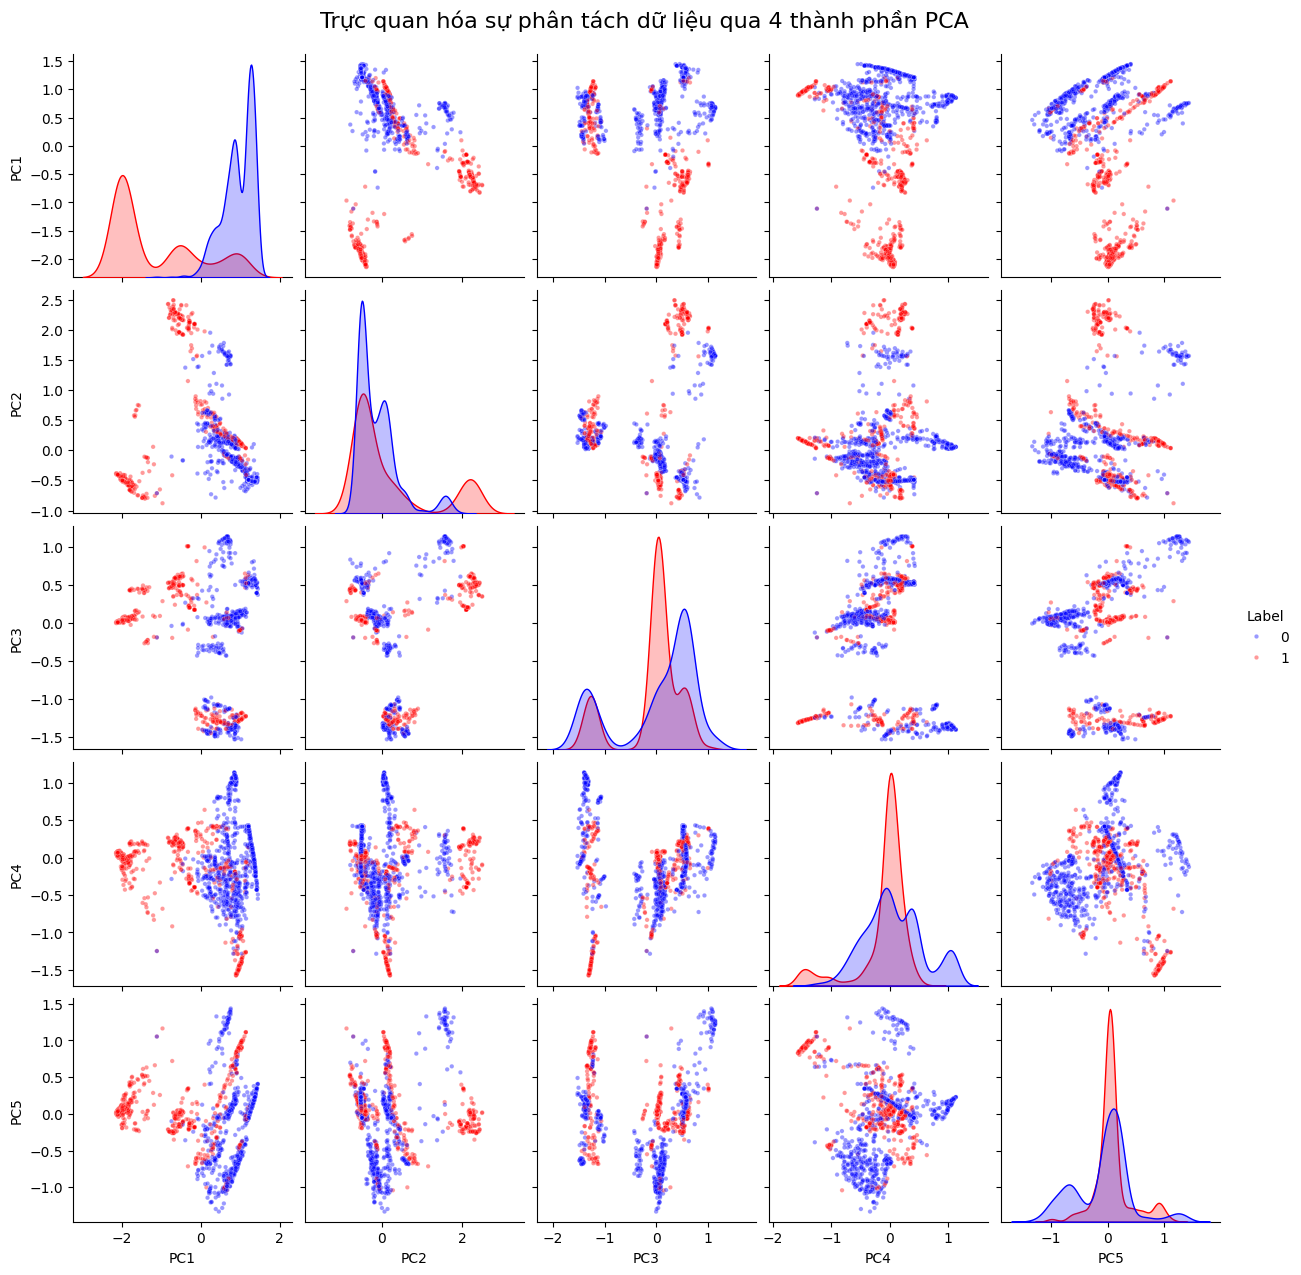

In [69]:
pca_df = pd.DataFrame(
    data=pca_result, 
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
)
pca_df['Label'] = y.values # Đảm bảo y là nhãn tương ứng (0: Normal, 1: Attack)

# 2. Vẽ Pairplot để xem mối quan hệ giữa cả 4 PCA
# Lưu ý: Vì tập dữ liệu NSL-KDD rất lớn, ta nên sample một phần để vẽ cho nhanh
grid = sns.pairplot(
    pca_df.sample(2000, random_state=42), # Lấy mẫu 2000 dòng để biểu đồ mượt mà
    hue='Label', 
    palette={0: 'blue', 1: 'red'},
    diag_kind='kde', # Vẽ biểu đồ phân phối ở đường chéo
    plot_kws={'alpha': 0.4, 's': 10} # Độ trong suốt và kích thước điểm
)

grid.fig.suptitle('Trực quan hóa sự phân tách dữ liệu qua 4 thành phần PCA', y=1.02, fontsize=16)
plt.show()

In [70]:
# Tính toán % phương sai được giữ lại
total_variance = np.sum(pca.explained_variance_ratio_) * 100
print(f"Tổng lượng thông tin (phương sai) được giữ lại: {total_variance:.2f}%")

# In chi tiết từng thành phần
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"Thành phần chính {i+1} (PC{i+1}): {ratio*100:.2f}%")

Tổng lượng thông tin (phương sai) được giữ lại: 77.02%
Thành phần chính 1 (PC1): 41.25%
Thành phần chính 2 (PC2): 15.65%
Thành phần chính 3 (PC3): 10.94%
Thành phần chính 4 (PC4): 5.07%
Thành phần chính 5 (PC5): 4.11%
